Experimental Pooling
=========================

Imports
-------

In [29]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

Load Data
---------

In [30]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = torchvision.datasets.CIFAR10(root="./cifardata", train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root="./cifardata", train=False, download=True, transform=transform)

classes = ('plane', 
           'car', 
           'bird',
           'cat',
           'deer', 
           'dog', 
           'frog', 
           'horse',
           'ship',
           'truck')

Files already downloaded and verified
Files already downloaded and verified


In [31]:
import logging

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def list_get(l, i, default=0):
    try:
        return l[i]
    except IndexError:
        return default
    
def plot_loss(n_epochs, training_losses, validation_losses):
    fig = plt.figure()
    ax = plt.axes()
    x = np.linspace(0, n_epochs, n_epochs)
    plt.plot(x, training_losses)
    plt.plot(x, validation_losses)
    ax.legend(["train_loss", "val_loss"])
    
def setup_logging(logfile):
    FORMAT = '[%(asctime)s.%(msecs)03d] %(message)s'
    DATEFMT = '%Y-%m-%d %H:%M:%S'
    logging.root.handlers = [] # clear logging from elsewhere
    logging.basicConfig(level=logging.INFO, format=FORMAT, datefmt=DATEFMT,
        handlers=[
            logging.FileHandler(logfile),
            logging.StreamHandler(sys.stdout)
    ])
    logger = logging.getLogger()
    return logger

In [32]:
from torch.utils.data.sampler import SubsetRandomSampler

#Training
n_training_samples = 20000
train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))
def get_train_loader(batch_size):
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler, num_workers=2)
        return train_loader
    
#Validation
n_val_samples = 5000
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples+n_val_samples, dtype=np.int64))
val_loader = torch.utils.data.DataLoader(train_set, batch_size=128, sampler=val_sampler, num_workers=2)

#Testing
n_test_samples = 5000
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4, sampler=test_sampler, num_workers=2)

In [50]:
class ExpPool:
    def __init__(self, channels, height, width):
        self.channels = channels
        self.height = height
        self.width = width
#         self.coeff = torch.rand(self.channels, self.height*self.width, requires_grad=True)
        self.coeff = torch.Tensor(self.channels, self.height*self.width)
        self.coeff.fill_(1/(self.height*self.width))
        self.coeff.requires_grad_(True)
        
    def forward(self, x):
        #Dimension changes from (N, C, H, W) to (N, C, H*W)
        x = x.view(-1, self.channels, self.height*self.width)
        
        #Sort the vector
#         x, indexes = torch.sort(x, dim=2)
        
        #Elementwise multiplication with trainable coefficient vector
        x = torch.mul(x, self.coeff)
        
        #Dimension changes from (N, C, H*W) to (N, C)
        y = torch.sum(x, dim=2)
        
        return y

In [51]:
from torch.autograd import Variable

class SimpleCNN(torch.nn.Module):
    
    #Batch shape of x: (3, 32, 32)
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        #Input channels = 3, Output channels = 18
        self.conv1 = torch.nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1)
        
        #Channels = 18, Height = Width = 32
        self.pool = ExpPool(18, 32, 32)
        
        #18432 input features, 64 output features
        self.fc1 = torch.nn.Linear(18, 64)
        
        #18 input features, 10 output features (for 10 defined classes)
        self.fc2 = torch.nn.Linear(64, 10)

                
        
    def forward(self, x):
        """
        Computes activation of the first convolution
        """
        #Dimension changes from (3, 32, 32) to (18, 32, 32)
        x = F.relu(self.conv1(x))
        
        #Dimension changes from (18, 32, 32) to (18)
        x = self.pool.forward(x)
        
        #Dimension changes from (18) to (64)
        x = F.relu(self.fc1(x))
        
        #Dimension changes from (64) to (10)
        x = self.fc2(x)
#         sm = F.softmax(x)

        return x
    
    
    def output_size(in_size, kernel_size, stride, padding):
        """
        Determines the output size
        """
        output = int((in_size - kernel_size + 2*padding) / stride) + 1
        
        return output

In [35]:
# from torch.autograd import Variable

# class SimpleCNN(torch.nn.Module):
    
#     #Batch shape of x: (3, 32, 32)
    
#     def __init__(self):
#         super(SimpleCNN, self).__init__()
        
#         #Input channels = 3, Output channels = 18
#         self.conv1 = torch.nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1)
        
#         #Channels = 18, Height = Width = 32
# #         self.pool = ExpPool(18, 32, 32)
#         self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
#         #18 input features, 10 output features (for 10 defined classes)
# #         self.fc = torch.nn.Linear(18, 10)
#         self.fc1 = torch.nn.Linear(18*16*16, 64)
#         self.fc2 = torch.nn.Linear(64, 10)
                
        
#     def forward(self, x):
#         """
#         Computes activation of the first convolution
#         """
#         #Dimension changes from (3, 32, 32) to (18, 32, 32)
#         x = F.relu(self.conv1(x))
        
#         #Dimension changes from (18, 32, 32) to (18, 1)
# #         x = self.pool.forward(x)
#         x = self.pool(x)
#         x = x.view(-1, 18*16*16)
        
# #         #Dimension changes from (1,18) to (1, 10)
# #         x = F.relu(self.fc(x))
        
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
        
# #         sm = F.softmax(x)

#         return x
    
    
#     def output_size(in_size, kernel_size, stride, padding):
#         """
#         Determines the output size
#         """
#         output = int((in_size - kernel_size + 2*padding) / stride) + 1
        
#         return output

In [36]:
import torch.optim as optim

def loss_optimizer_scheduler(net, learning_rate=0.001):
    """
    Initializes the loss optimizer functions
    """
    loss = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=0, verbose=True)
    
    return loss, optimizer, scheduler

In [43]:
import time
import matplotlib.pyplot as plt

def trainNet(net, batch_size, n_epochs, learning_rate):
    
    #Print all of the hyperparameters of the training iteration:
    print("===== HYPERPARAMETERS =====")
    print("batch_size =", batch_size)
    print("epochs =", n_epochs)
    print("learning_rate =", learning_rate)
    print("=" * 30)
    
    validation_losses = []
    training_losses = []
    
    #Retrieve training data
    train_loader = get_train_loader(batch_size)
    n_batches = len(train_loader)
    
    #Initialize loss and optimizer functions
    loss, optimizer, scheduler = loss_optimizer_scheduler(net, learning_rate)
    
    
    training_start_time = time.time()
    for epoch in range(n_epochs):
        
        running_loss = 0.0
        print_every = n_batches // 10
#         print_every = 1 if print_every == 0 else print_every
        start_time = time.time()
        total_train_loss = 0
        
        for i, data in enumerate(train_loader, 0):
            
            #Get inputs
            inputs, labels = data
#             if epoch == 0:
#                 global img
#                 img = inputs
#                 target = inputs[0]
#                 imshow(target)
#                 print(classes[labels[0]])
            inputs, labels = Variable(inputs), Variable(labels)   
                        
            #Set parameter gradients to zero
            optimizer.zero_grad()
            
            #Forward pass, backward pass, optimize
            outputs = net(inputs)            
            loss_size = loss(outputs, labels)
            
            #Intermediate accuracy
#             _, predicted = torch.max(outputs.data, dim=1)
#             num_correct = (predicted == labels).sum().item()
#             intermediate_acc = (num_correct * 100.0 / labels.size(0))
            
            loss_size.backward()
            optimizer.step()
            
            #Update statistics
            running_loss += loss_size.data.item()
            total_train_loss += loss_size.data.item()
            
            
            #Print statistics every 10th batch of epoch
            if (i+1) % (print_every+1) == 0:
                print("Epoch {epoch}, {percent_complete_epoch:d}% \t train_loss: {train_loss:.2f} \t took: {time:.2f}s".format(
                    epoch = epoch+1, 
                    percent_complete_epoch = int(100 * (i+1) / n_batches), 
                    train_loss = running_loss / print_every, 
                    time = time.time() - start_time, 
#                     accuracy = intermediate_acc.item()
                ))
                
                #Reset running loss and time
                running_loss = 0.0
                start_time = time.time()
            
        #After each epoch, run a pass on validation set
        total_val_loss = 0
        
        for inputs, labels in val_loader:
            
            inputs, labels = Variable(inputs), Variable(labels)
            
            #Forward pass
            val_outputs = net(inputs)
            val_loss_size = loss(val_outputs, labels)
            total_val_loss += val_loss_size.data.item()
        
        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))
        
        validation_losses.append(total_val_loss / len(val_loader))
        training_losses.append(total_train_loss / len(train_loader))
        scheduler.step(total_val_loss / len(val_loader))
        
        
        
    print("=" * 30)
    print("Training finished, took {:.2f}s".format(time.time() - training_start_time))
    
    plot_loss(n_epochs=n_epochs, 
              training_losses=training_losses, 
              validation_losses=validation_losses)
    

In [38]:
def accuracy(model):
    
    correct = 0
    total = 0
    
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
    
    with torch.no_grad():
        
        for data in test_loader:

            #Run test data through model
            inputs, labels = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, dim=1)
            
            
            #Updte statistics
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            #Class specific 
            c = (predicted == labels).squeeze()
            for i in range(len(predicted)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
        
        #Report accuracies
        overall_acc = (correct * 100.0) / total
        class_acc = {}
        for i in range(len(classes)):
            class_acc[classes[i]] = (class_correct[i] * 100) / class_total[i]
                

    return overall_acc, class_acc

===== HYPERPARAMETERS =====
batch_size = 32
epochs = 10
learning_rate = 0.001
Epoch 1, 10% 	 train_loss: 2.32 	 took: 0.82s
Epoch 1, 20% 	 train_loss: 2.27 	 took: 0.64s
Epoch 1, 30% 	 train_loss: 2.19 	 took: 0.66s
Epoch 1, 40% 	 train_loss: 2.14 	 took: 0.73s
Epoch 1, 50% 	 train_loss: 2.12 	 took: 0.71s
Epoch 1, 60% 	 train_loss: 2.10 	 took: 0.58s
Epoch 1, 70% 	 train_loss: 2.10 	 took: 0.57s
Epoch 1, 80% 	 train_loss: 2.06 	 took: 0.63s
Epoch 1, 90% 	 train_loss: 2.04 	 took: 0.57s
Validation loss = 1.98
Epoch 2, 10% 	 train_loss: 2.04 	 took: 0.66s
Epoch 2, 20% 	 train_loss: 2.02 	 took: 0.63s
Epoch 2, 30% 	 train_loss: 2.02 	 took: 0.60s
Epoch 2, 40% 	 train_loss: 2.00 	 took: 0.57s
Epoch 2, 50% 	 train_loss: 1.98 	 took: 0.59s
Epoch 2, 60% 	 train_loss: 2.00 	 took: 1.20s
Epoch 2, 70% 	 train_loss: 1.99 	 took: 0.66s
Epoch 2, 80% 	 train_loss: 2.00 	 took: 0.58s
Epoch 2, 90% 	 train_loss: 1.96 	 took: 0.57s
Validation loss = 1.92
Epoch 3, 10% 	 train_loss: 1.95 	 took: 0.76s
Ep

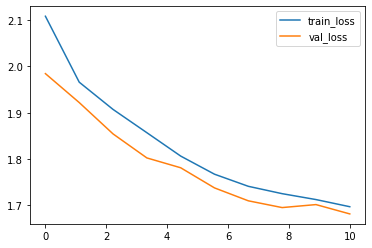

In [52]:
import json

CNN = SimpleCNN()
trainNet(CNN, batch_size=32, n_epochs=10, learning_rate=.001)
overall_acc, class_acc = accuracy(CNN)
print("Final Accuracy: \n overall: {overall_acc:.3f} \n class: {class_acc}".format(
    overall_acc=overall_acc, 
    class_acc=json.dumps(class_acc, indent=4)))

# outputs = CNN(img)
# x = classes
# y = np.ndarray.flatten(torch.nn.functional.softmax(outputs, dim=1).data.numpy())
# fig = plt.figure()
# ax = plt.axes()
# plt.bar(x, y)

# _, predicted = torch.max(outputs, 1)
# print("Predicted:", classes[predicted[0]])

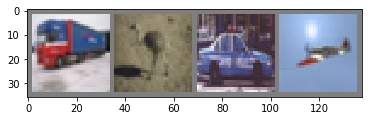

GroundTruth:  truck  bird   car plane
Predicted:  truck  bird truck  ship


In [135]:
#Show images

dataiter = iter(test_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = CNN(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))